<a href="https://colab.research.google.com/github/PradyumnaCharate/Flower-Species-Recognition/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet

In [20]:
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch
import torchvision

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/alxmamaev/flowers-recognition")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pradyumnacharate
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:09<00:00, 25.6MB/s]


#Import the dataset into pytorch

In [4]:
data_dir="./flowers-recognition/flowers"

In [5]:
for cls in os.listdir(data_dir):
  print(cls,":",len(os.listdir(data_dir+"/"+cls)))

dandelion : 1052
daisy : 764
sunflower : 733
rose : 784
tulip : 984


In [6]:
dataset=ImageFolder(data_dir)

In [7]:
len(dataset)

4317

In [8]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

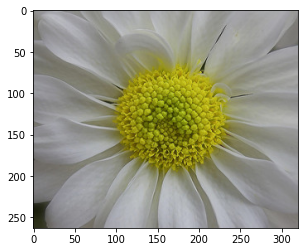

In [9]:
import matplotlib.pyplot as plt
image,label=dataset[0]
plt.imshow(image)

In [34]:
dataset=ImageFolder(data_dir,tt.Compose([tt.Resize(64),
                                         tt.RandomCrop(64),
                                         tt.ToTensor()]))

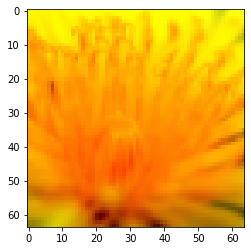

In [35]:
import matplotlib.pyplot as plt
image,label=dataset[1501]
plt.imshow(image.permute(1,2,0))

In [36]:
val_percentage=0.1
val_size=int(val_percentage*len(dataset))
train_size=len(dataset)-val_size
train_size,val_size

(3886, 431)

In [37]:
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds)

3886

In [38]:
batch_size=128
train_dl=DataLoader(train_ds,
                    batch_size,
                    shuffle=True,
                    num_workers=2,
                    pin_memory=True
                    )
val_dl=DataLoader(val_ds,
                    batch_size*2,
                    shuffle=True,
                    num_workers=2,
                    pin_memory=True
                    )

In [15]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        #denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break


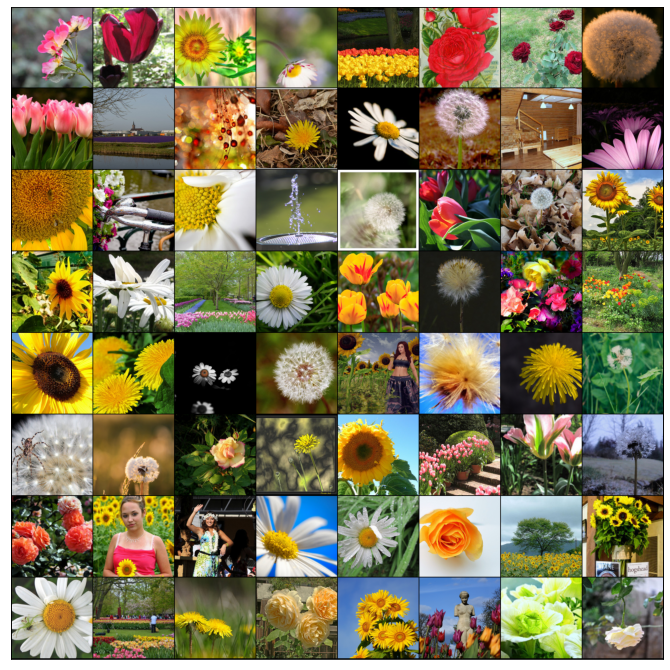

In [16]:
show_batch(train_dl)

## Using a GPU:

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

#Utilities and Functions

In [41]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [55]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [56]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#Model

In [57]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

#Training the Model

In [67]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [59]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [68]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.21689732372760773, 'val_loss': 1.6112086772918701}]

In [69]:
history += fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.4822, val_loss: 1.7177, val_acc: 0.3268
Epoch [1], train_loss: 1.0299, val_loss: 1.0021, val_acc: 0.6409
Epoch [2], train_loss: 0.9036, val_loss: 0.8799, val_acc: 0.6567
Epoch [3], train_loss: 0.8028, val_loss: 1.0949, val_acc: 0.6161
Epoch [4], train_loss: 0.7219, val_loss: 1.4459, val_acc: 0.5871


In [70]:
history += fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.8018, val_loss: 0.8773, val_acc: 0.6561
Epoch [1], train_loss: 0.6763, val_loss: 0.6232, val_acc: 0.7642
Epoch [2], train_loss: 0.6096, val_loss: 0.6605, val_acc: 0.7320
Epoch [3], train_loss: 0.5585, val_loss: 0.6853, val_acc: 0.7681
Epoch [4], train_loss: 0.5228, val_loss: 0.8481, val_acc: 0.7019


In [71]:
history += fit(5,0.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.4051, val_loss: 0.4527, val_acc: 0.8371
Epoch [1], train_loss: 0.3583, val_loss: 0.4057, val_acc: 0.8580
Epoch [2], train_loss: 0.3383, val_loss: 0.4207, val_acc: 0.8689
Epoch [3], train_loss: 0.3199, val_loss: 0.3923, val_acc: 0.8562
Epoch [4], train_loss: 0.3023, val_loss: 0.4080, val_acc: 0.8536


In [61]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

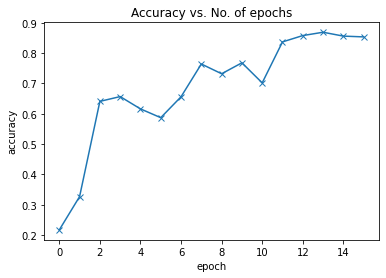

In [72]:
plot_accuracies(history)

In [63]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

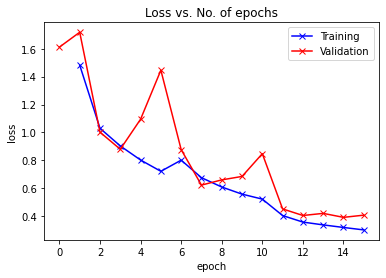

In [73]:
plot_losses(history)

In [74]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: sunflower , Predicted: sunflower


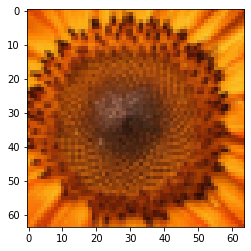

In [81]:
img, label = val_ds[91]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

#Saving and loading the model

In [79]:
torch.save(model.state_dict(), 'flower-regognition.pth')